In [23]:
from pathlib import Path
from xpinn import XPINN
from pinn import PINN
import optax
from type_util import Array
from jax import jacobian, jit, vmap
import jax.numpy as np
import numpy as onp

In [24]:
from utils import data_path

file_test_simple = data_path / "test_advection_simple.json"
single_pinn = XPINN(file_test_simple, np.tanh)

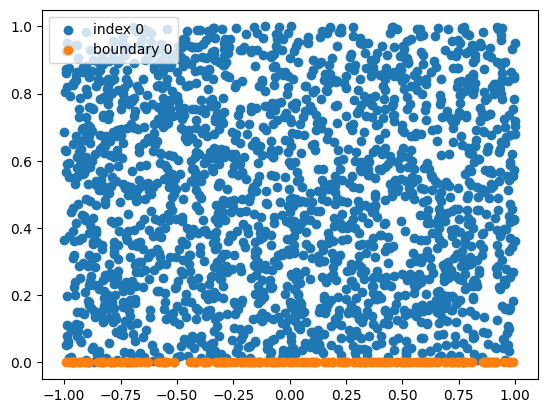

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(single_pinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

plt.legend()

In [26]:
### Creating boundary loss : obs (we apply the model in the definitions)
from typing import Callable
from type_util import Params

LFunc = Callable[[Params, dict[str, Array]], Array]


def boundary_loss_factory(pinn_model:PINN, target: float | Array) -> LFunc:
    def boundary_loss(params: Params, args: dict[str, Array]) -> Array:
        points = args["boundary"]
        eval = pinn_model.v_model(params, points)
        return np.mean((eval - target) ** 2)

    return boundary_loss

# fmt: off
def interior_loss_factory(pinn_model:PINN, alpha: float = 0.5) -> LFunc:
    model = pinn_model.model
    jacob = lambda params: jacobian(lambda x: model(params, x))
    N_dx = lambda params, x: jacob(params)(x)[0, 0]
    N_dt = lambda params, x: jacob(params)(x)[0, 1]
    residual = lambda params, x: (N_dt(params, x) + alpha * N_dx(params, x))
    # v_residual = vmap(residual, (None, 0))
    v_residual = jit(vmap(residual, (None, 0)))
    pinn_model.v_residual = v_residual

    def interior_loss(params: Params, args: dict[str, Array]) -> Array:
        points = args["interior"]
        return np.mean(v_residual(params, points) ** 2)

    return interior_loss
# fmt: on

In [27]:
### Implementing Initial Value: idea is to take all boundary points (initial value points) and precompute their values. 
import numpy as onp
def eval(x):
    a = 0
    if -0.2<=x[0]<=0.2:
        a=1
    return a

def f():
    points=single_pinn.PINNs[0].boundary
    f=onp.zeros_like(points)
    for i,point in enumerate(points):
        f[i] = eval(point)
    return np.array(f)

IV = f()

In [28]:
### Initializing losses

p = single_pinn.PINNs[0]
print(single_pinn.PINNs)

# This should ensure the physical constraints are satisfied
p.interior_loss = interior_loss_factory(p, alpha=0.5)
p.boundary_loss = boundary_loss_factory(p, IV)
p.create_loss()


<PjitFunction of <function PINN.create_loss.<locals>.loss at 0x29e7b8900>>

In [29]:
###Setting up optimizer
shapes = [[2] + [20] * 6 + [1]]
optimizer = optax.adam(learning_rate=1e-3)
single_pinn.initialize_params(shapes, optimizer)

/Users/junmiaohu/Documents/UiO/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return scale * random.normal(
/Users/junmiaohu/Documents/UiO/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:26: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ), scale * random.normal(b_key, (n,), dtype=np.float64)


In [30]:
# Run the iterations
n_iter = 10000
simple_losses = single_pinn.run_iters(n_iter)

0.00% iter = 0 of 10000: Total loss = 0.43777576088905334
10.00% iter = 1000 of 10000: Total loss = 0.003369933692738414
20.00% iter = 2000 of 10000: Total loss = 0.0006050830706954002
30.00% iter = 3000 of 10000: Total loss = 4.899307532468811e-05
40.00% iter = 4000 of 10000: Total loss = 5.344916644389741e-05
50.00% iter = 5000 of 10000: Total loss = 1.1600468496908434e-05
60.00% iter = 6000 of 10000: Total loss = 7.170701792347245e-06
70.00% iter = 7000 of 10000: Total loss = 4.319681465858594e-06
80.00% iter = 8000 of 10000: Total loss = 2.7272774332232075e-06
90.00% iter = 9000 of 10000: Total loss = 2.308837792952545e-06
100.00% iter = 10000 of 10000: Total loss = 1.4143561202217825e-06


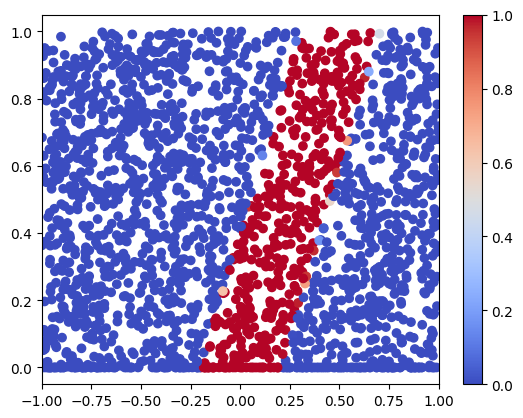

In [31]:
points, predictions = single_pinn.predict(file_test_simple)
total_pred = np.concatenate(predictions)

for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm")
    plt.clim(0, 1)

plt.xlim(-1, 1)
plt.colorbar()